In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from pandas import DataFrame , concat
from sklearn.metrics import mean_absolute_error , mean_squared_error, mean_absolute_percentage_error
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from numpy import mean , concatenate
from math import sqrt
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Activation
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

from numpy import array , hstack
from tensorflow import keras
import tensorflow as tf

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# define where the cleaned_data.csv is stored
path = '/content/drive/MyDrive/pv/cleaned_data.csv'

# load the data from the csv file
dataset = pd.read_csv(path, parse_dates=True, index_col='Time')


# add some features 
dataset['hour'] = dataset.index.hour
dataset['month'] = dataset.index.month

def add_lags(df):
    target_map = df['PV_Power'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('1 hour')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('2 hour')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('3 hour')).map(target_map)
    df['lag4'] = (df.index - pd.Timedelta('6 hour')).map(target_map)

    return df

dataset = add_lags(dataset)
dataset = dataset.dropna()

# define the features to use and the target important that last column has to
# be the target in this case 'PV_Power'
dataset = dataset[['T_air', 'G_tilt', 'lag1', 'PV_Power']]

In [3]:
def preprocess_data(dataset):
  """
  Scales and shapes the dataset for the splitting.

  RETURNS:
  the new dataset, and the scaler of the target column.
  """
  features = dataset.columns[:-1]
  target = dataset.columns[-1] # very important that target is in last position
  xs = []
  for feature in features:
    xs.append(dataset[feature].values)
  y = dataset[target].values

  # convert to [rows, columns] structure
  xs_converted = []
  for x in xs:
    xs_converted.append(x.reshape((-1, 1)))
  y = y.reshape(-1, 1)

  # normalization
  scaler = MinMaxScaler(feature_range=(0, 1))
  xs_scaled = []
  for x in xs_converted:
    xs_scaled.append(scaler.fit_transform(x))
  y_scaled = scaler.fit_transform(y) # important that y is scaled last

  # horizontally stacked columns
  xs_scaled.append(y_scaled)
  stack = xs_scaled
  dataset_stacked = hstack(tuple(stack))



  return scaler, dataset_stacked

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    """
    Splits the the multivariate sequence into samples.

    PARAMETERS:
    n_steps_in - LSTM sliding window size (eg. 24 hours)
    n_steps_out - amount of hours ahead we want to predict
    
    RETRUNS:
    numpy arrays where X is the features, and Y is the target
    """
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)
    


def fit_lstm(train_X, train_y, valid_X, valid_y, n_steps_in, n_steps_out, n_features):
  """
  Defines the model, and also compiles and fits the model for the training sets.
  Model config and parameters can be tuned for better performance.
  As of now stacked lstm works best.

  
  PARAMETERS:
  train_X - used for training
  train_y - used for training
  valid_X - used for validation
  valid_y - used for validation
  n_steps_in - lstm sliding window size, important that its the same as we used
    in the split_sequences function
  n_steps_out - amount of hours ahead we want to predict, important that 
    its the same as we used in the split_sequences function
  n_features - the number of features we are using for the prediction

  RETURNS:
  the trained model and the history so we can visualize the training procedure
  """
  EPOCHS = 496
  VERBOSE = 1
  BATCH_SIZE = 32
  
  opt = keras.optimizers.Adam(learning_rate=0.001)

  # define model
  model = Sequential()
  model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
  model.add(LSTM(64, activation='relu'))
  model.add(Dense(n_steps_out))


  model.compile(loss='mse' , optimizer=opt , metrics=[tf.keras.metrics.RootMeanSquaredError()])

  cp = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/pv/model_lstm/', save_best_only=True)

  history = model.fit(train_X , train_y,
                      epochs=EPOCHS,
                      batch_size = BATCH_SIZE,
                      verbose=VERBOSE,
                      validation_data=(valid_X, valid_y),
                      callbacks =[keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
                                  cp,
                                  ],
                      shuffle=False)

  return model, history

def evaluate_forecasts(test, forecasts,  n_steps_in, n_steps_out):
    """
    Prints error metrics: RMSE, MAE, MAPE.

    test - true values
    forecasts - predicted values
    n_steps_in - lstm sliding window size, important that its the same as we used
      in the split_sequences function
    n_steps_out - amount of hours ahead we want to predict, important that 
      its the same as we used in the split_sequences function

    """

    for i in range(n_steps_out):
        rmse = np.sqrt(mean_squared_error(test[:, i], forecasts[:, i]))
        print('t+%d RMSE: %f' % ((i+1), rmse), end=" ")
        print('MAE:  %f' % (mean_absolute_error(test[:, i], forecasts[:, i])), end=" ")
        print('MAPE: %f' % (mean_absolute_percentage_error(test[:, i], forecasts[:, i])))

def plot_training_history(history):
  """
  Plot the error metrics measured during the training.
  """

  plt.plot(history.history['root_mean_squared_error'])
  plt.plot(history.history['val_root_mean_squared_error'])
  plt.title('model root mean squared error')
  plt.ylabel('rmse')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()


  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()


## Example usage


In [4]:

# configure
n_features = 3
n_steps_in , n_steps_out = 24, 3

scaler, dataset_stacked = preprocess_data(dataset)

# convert into input/output
X, y = split_sequences(dataset_stacked, n_steps_in, n_steps_out)


# Train Validation Test Split
from sklearn.model_selection import train_test_split
train_X, test_X,train_y, test_y = train_test_split(X, y, test_size = 0.2, shuffle=False)
train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, test_size= 0.2, shuffle=False)




In [5]:
# fits the lstm, comment this out if you only want to load the best model, 
# but make sure that that model you are loading was trained
# with the same parameters
model, history = fit_lstm(train_X, train_y, valid_X, valid_y, n_steps_in, n_steps_out, n_features)


Epoch 1/496
173/173 [==============================] - ETA: 0s - loss: 0.0300 - root_mean_squared_error: 0.1733

173/173 [==============================] - 33s 149ms/step - loss: 0.0300 - root_mean_squared_error: 0.1733 - val_loss: 0.0177 - val_root_mean_squared_error: 0.1332
Epoch 2/496
172/173 [============================>.] - ETA: 0s - loss: 0.0188 - root_mean_squared_error: 0.1370

173/173 [==============================] - 19s 112ms/step - loss: 0.0188 - root_mean_squared_error: 0.1370 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1156
Epoch 3/496
173/173 [==============================] - ETA: 0s - loss: 0.0145 - root_mean_squared_error: 0.1204

173/173 [==============================] - 23s 133ms/step - loss: 0.0145 - root_mean_squared_error: 0.1204 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1028
Epoch 4/496
173/173 [==============================] - ETA: 0s - loss: 0.0125 - root_mean_squared_error: 0.1120

173/173 [==============================] - 19s 110ms/step - loss: 0.0125 - root_mean_squared_error: 0.1120 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1013
Epoch 5/496
173/173 [==============================] - ETA: 0s - loss: 0.0120 - root_mean_squared_error: 0.1097

173/173 [==============================] - 16s 93ms/step - loss: 0.0120 - root_mean_squared_error: 0.1097 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0993
Epoch 6/496
172/173 [============================>.] - ETA: 0s - loss: 0.0115 - root_mean_squared_error: 0.1071

173/173 [==============================] - 16s 96ms/step - loss: 0.0115 - root_mean_squared_error: 0.1071 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0986
Epoch 7/496
172/173 [============================>.] - ETA: 0s - loss: 0.0109 - root_mean_squared_error: 0.1046

173/173 [==============================] - 17s 97ms/step - loss: 0.0109 - root_mean_squared_error: 0.1046 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0968
Epoch 8/496
173/173 [==============================] - ETA: 0s - loss: 0.0105 - root_mean_squared_error: 0.1025

173/173 [==============================] - 17s 96ms/step - loss: 0.0105 - root_mean_squared_error: 0.1025 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0952
Epoch 9/496
172/173 [============================>.] - ETA: 0s - loss: 0.0101 - root_mean_squared_error: 0.1003

173/173 [==============================] - 16s 93ms/step - loss: 0.0101 - root_mean_squared_error: 0.1003 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0940
Epoch 10/496
173/173 [==============================] - ETA: 0s - loss: 0.0097 - root_mean_squared_error: 0.0985

173/173 [==============================] - 21s 120ms/step - loss: 0.0097 - root_mean_squared_error: 0.0985 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0929
Epoch 11/496
172/173 [============================>.] - ETA: 0s - loss: 0.0093 - root_mean_squared_error: 0.0965

173/173 [==============================] - 16s 93ms/step - loss: 0.0093 - root_mean_squared_error: 0.0965 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0919
Epoch 12/496
173/173 [==============================] - ETA: 0s - loss: 0.0089 - root_mean_squared_error: 0.0941

173/173 [==============================] - 17s 101ms/step - loss: 0.0089 - root_mean_squared_error: 0.0941 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0914
Epoch 13/496
172/173 [============================>.] - ETA: 0s - loss: 0.0086 - root_mean_squared_error: 0.0929

173/173 [==============================] - 16s 90ms/step - loss: 0.0086 - root_mean_squared_error: 0.0929 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0910
Epoch 14/496
173/173 [==============================] - ETA: 0s - loss: 0.0085 - root_mean_squared_error: 0.0921

173/173 [==============================] - 16s 92ms/step - loss: 0.0085 - root_mean_squared_error: 0.0921 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0907
Epoch 15/496
173/173 [==============================] - ETA: 0s - loss: 0.0083 - root_mean_squared_error: 0.0910

173/173 [==============================] - 15s 88ms/step - loss: 0.0083 - root_mean_squared_error: 0.0910 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0902
Epoch 16/496
172/173 [============================>.] - ETA: 0s - loss: 0.0081 - root_mean_squared_error: 0.0901

173/173 [==============================] - 15s 89ms/step - loss: 0.0081 - root_mean_squared_error: 0.0901 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0902
Epoch 17/496
173/173 [==============================] - ETA: 0s - loss: 0.0080 - root_mean_squared_error: 0.0893

173/173 [==============================] - 15s 89ms/step - loss: 0.0080 - root_mean_squared_error: 0.0893 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0901
Epoch 18/496
173/173 [==============================] - ETA: 0s - loss: 0.0078 - root_mean_squared_error: 0.0886

173/173 [==============================] - 15s 87ms/step - loss: 0.0078 - root_mean_squared_error: 0.0886 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0897
Epoch 19/496
173/173 [==============================] - 11s 65ms/step - loss: 0.0077 - root_mean_squared_error: 0.0879 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0898
Epoch 20/496
173/173 [==============================] - 10s 58ms/step - loss: 0.0082 - root_mean_squared_error: 0.0906 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0921
Epoch 21/496
173/173 [==============================] - 11s 62ms/step - loss: 0.0088 - root_mean_squared_error: 0.0936 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0904
Epoch 22/496
173/173 [==============================] - ETA: 0s - loss: 0.0084 - root_mean_squared_error: 0.0918

173/173 [==============================] - 16s 94ms/step - loss: 0.0084 - root_mean_squared_error: 0.0918 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0896
Epoch 23/496
173/173 [==============================] - 12s 70ms/step - loss: 0.0082 - root_mean_squared_error: 0.0906 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0897
Epoch 24/496
173/173 [==============================] - 12s 72ms/step - loss: 0.0080 - root_mean_squared_error: 0.0896 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0897
Epoch 25/496
173/173 [==============================] - ETA: 0s - loss: 0.0078 - root_mean_squared_error: 0.0886

173/173 [==============================] - 16s 95ms/step - loss: 0.0078 - root_mean_squared_error: 0.0886 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0896
Epoch 26/496
173/173 [==============================] - 13s 74ms/step - loss: 0.0077 - root_mean_squared_error: 0.0876 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0897
Epoch 27/496
173/173 [==============================] - ETA: 0s - loss: 0.0075 - root_mean_squared_error: 0.0867

173/173 [==============================] - 17s 96ms/step - loss: 0.0075 - root_mean_squared_error: 0.0867 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0895
Epoch 28/496
173/173 [==============================] - 12s 69ms/step - loss: 0.0074 - root_mean_squared_error: 0.0858 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0896
Epoch 29/496
173/173 [==============================] - ETA: 0s - loss: 0.0073 - root_mean_squared_error: 0.0852

173/173 [==============================] - 16s 95ms/step - loss: 0.0073 - root_mean_squared_error: 0.0852 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0895
Epoch 30/496
173/173 [==============================] - ETA: 0s - loss: 0.0072 - root_mean_squared_error: 0.0846

173/173 [==============================] - 16s 94ms/step - loss: 0.0072 - root_mean_squared_error: 0.0846 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0892
Epoch 31/496
173/173 [==============================] - 12s 71ms/step - loss: 0.0071 - root_mean_squared_error: 0.0841 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0893
Epoch 32/496
173/173 [==============================] - 11s 65ms/step - loss: 0.0070 - root_mean_squared_error: 0.0835 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0896
Epoch 33/496
173/173 [==============================] - 11s 62ms/step - loss: 0.0069 - root_mean_squared_error: 0.0828 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0893
Epoch 34/496
173/173 [==============================] - 11s 63ms/step - loss: 0.0068 - root_mean_squared_error: 0.0825 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0898
Epoch 35/496
173/173 [==============================] - 12s 70ms/step - loss: 0.0067 - root_mean_squared_error: 0.0820 - val_loss: 0.

173/173 [==============================] - 15s 90ms/step - loss: 0.0067 - root_mean_squared_error: 0.0818 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0890
Epoch 39/496
173/173 [==============================] - 12s 68ms/step - loss: 0.0065 - root_mean_squared_error: 0.0807 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0891
Epoch 40/496
172/173 [============================>.] - ETA: 0s - loss: 0.0064 - root_mean_squared_error: 0.0799

173/173 [==============================] - 16s 90ms/step - loss: 0.0064 - root_mean_squared_error: 0.0799 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0887
Epoch 41/496
173/173 [==============================] - 10s 58ms/step - loss: 0.0063 - root_mean_squared_error: 0.0795 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0889
Epoch 42/496
173/173 [==============================] - 11s 61ms/step - loss: 0.0062 - root_mean_squared_error: 0.0791 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0891
Epoch 43/496
173/173 [==============================] - 12s 69ms/step - loss: 0.0062 - root_mean_squared_error: 0.0786 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0888
Epoch 44/496
173/173 [==============================] - 12s 69ms/step - loss: 0.0062 - root_mean_squared_error: 0.0786 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0887
Epoch 45/496
173/173 [==============================] - 11s 64ms/step - loss: 0.0062 - root_mean_squared_error: 0.0785 - val_loss: 0.

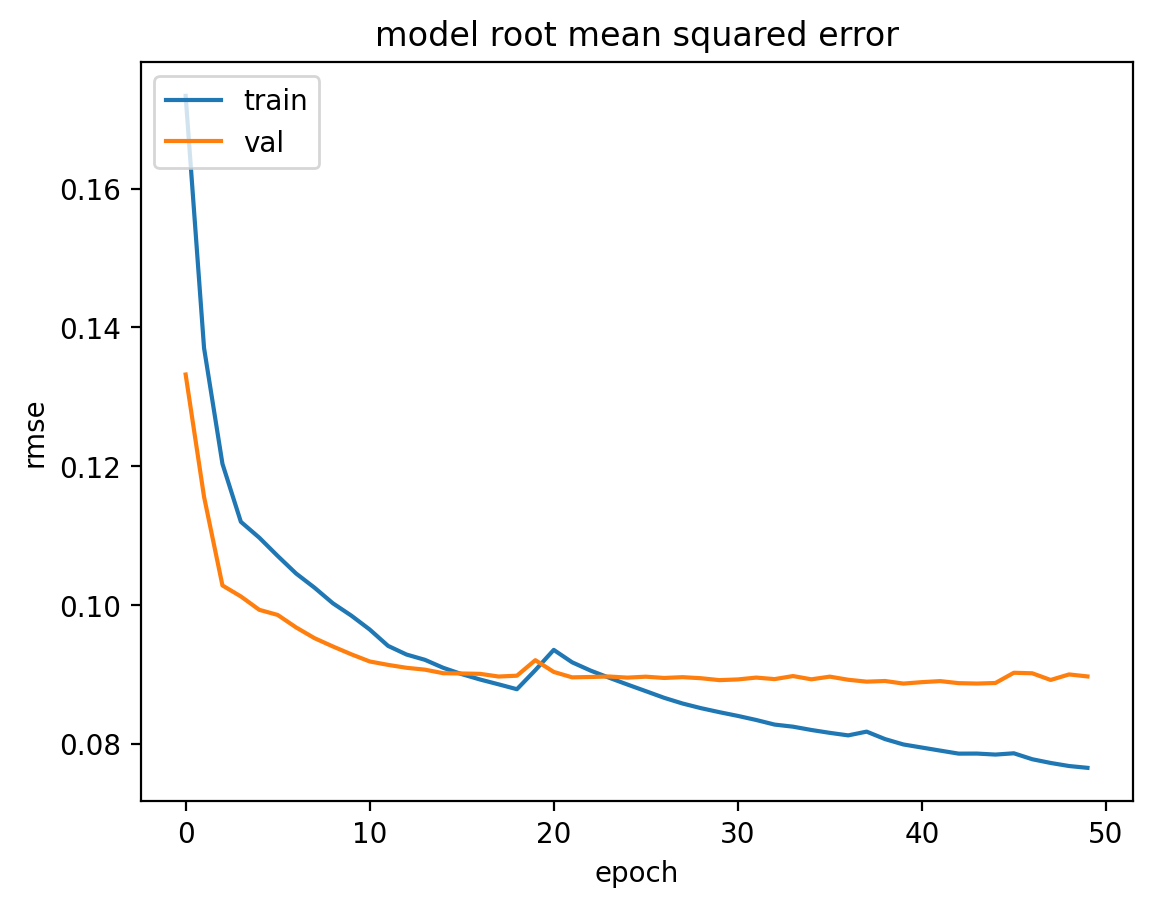

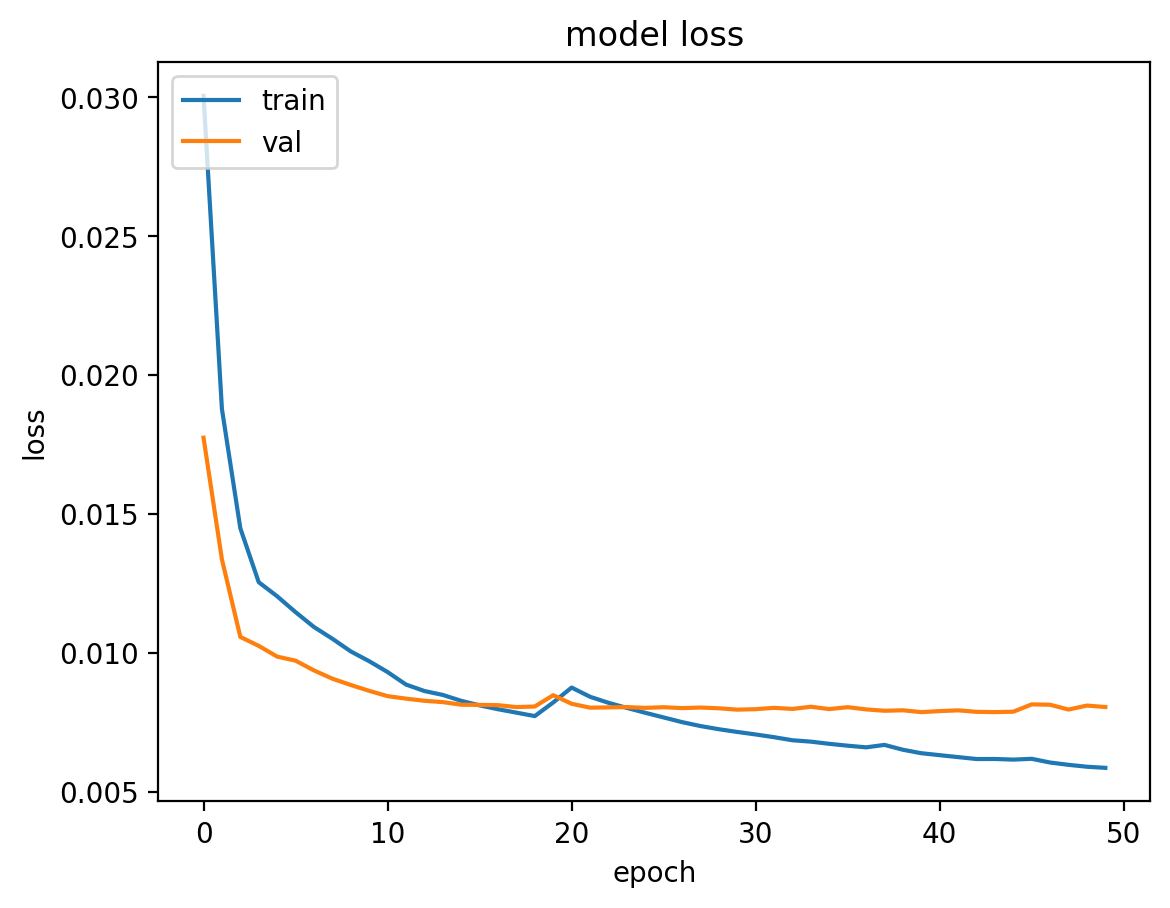

In [6]:
plot_training_history(history)

In [7]:
# load the best model
model = keras.models.load_model('/content/drive/MyDrive/pv/model_lstm/')

forecasts = model.predict(test_X)
forecasts = scaler.inverse_transform(forecasts)
actuals = scaler.inverse_transform(test_y)

55/55 [==============================] - 1s 17ms/step


In [8]:
# evalute the model
evaluate_forecasts(actuals, forecasts, n_steps_in, n_steps_out)

t+1 RMSE: 7.096446 MAE:  2.821945 MAPE: 1.281153
t+2 RMSE: 19.651424 MAE:  9.410577 MAPE: 1.586897
t+3 RMSE: 25.725664 MAE:  13.800363 MAPE: 3.584065


In [9]:
# plot predicted values to true values
def plot_forecasts(test, forecasts):
  """
  Plots the predicted values and the true values for every n_steps_out.
  (n_steps_out = 3 -> t+1, t+2, t+3 graphs)

  PARAMETERS:
  test - true values
  forecasts - predicted values

  """

  fig, ax = plt.subplots(forecasts.shape[1], 1, figsize=(15,15))

  for i, ax in zip(range(forecasts.shape[1]), ax.flatten()):
    by_hours = pd.DataFrame(data={'Predictions': forecasts[:, i], 'Actuals': test[:, i]})
    ax.plot(by_hours['Predictions'][0:700], 'r', label=f't+{i+1} preds')
    ax.plot(by_hours['Actuals'][0:700], marker='.', label=f't+{i+1} trues')
    ax.legend()
    

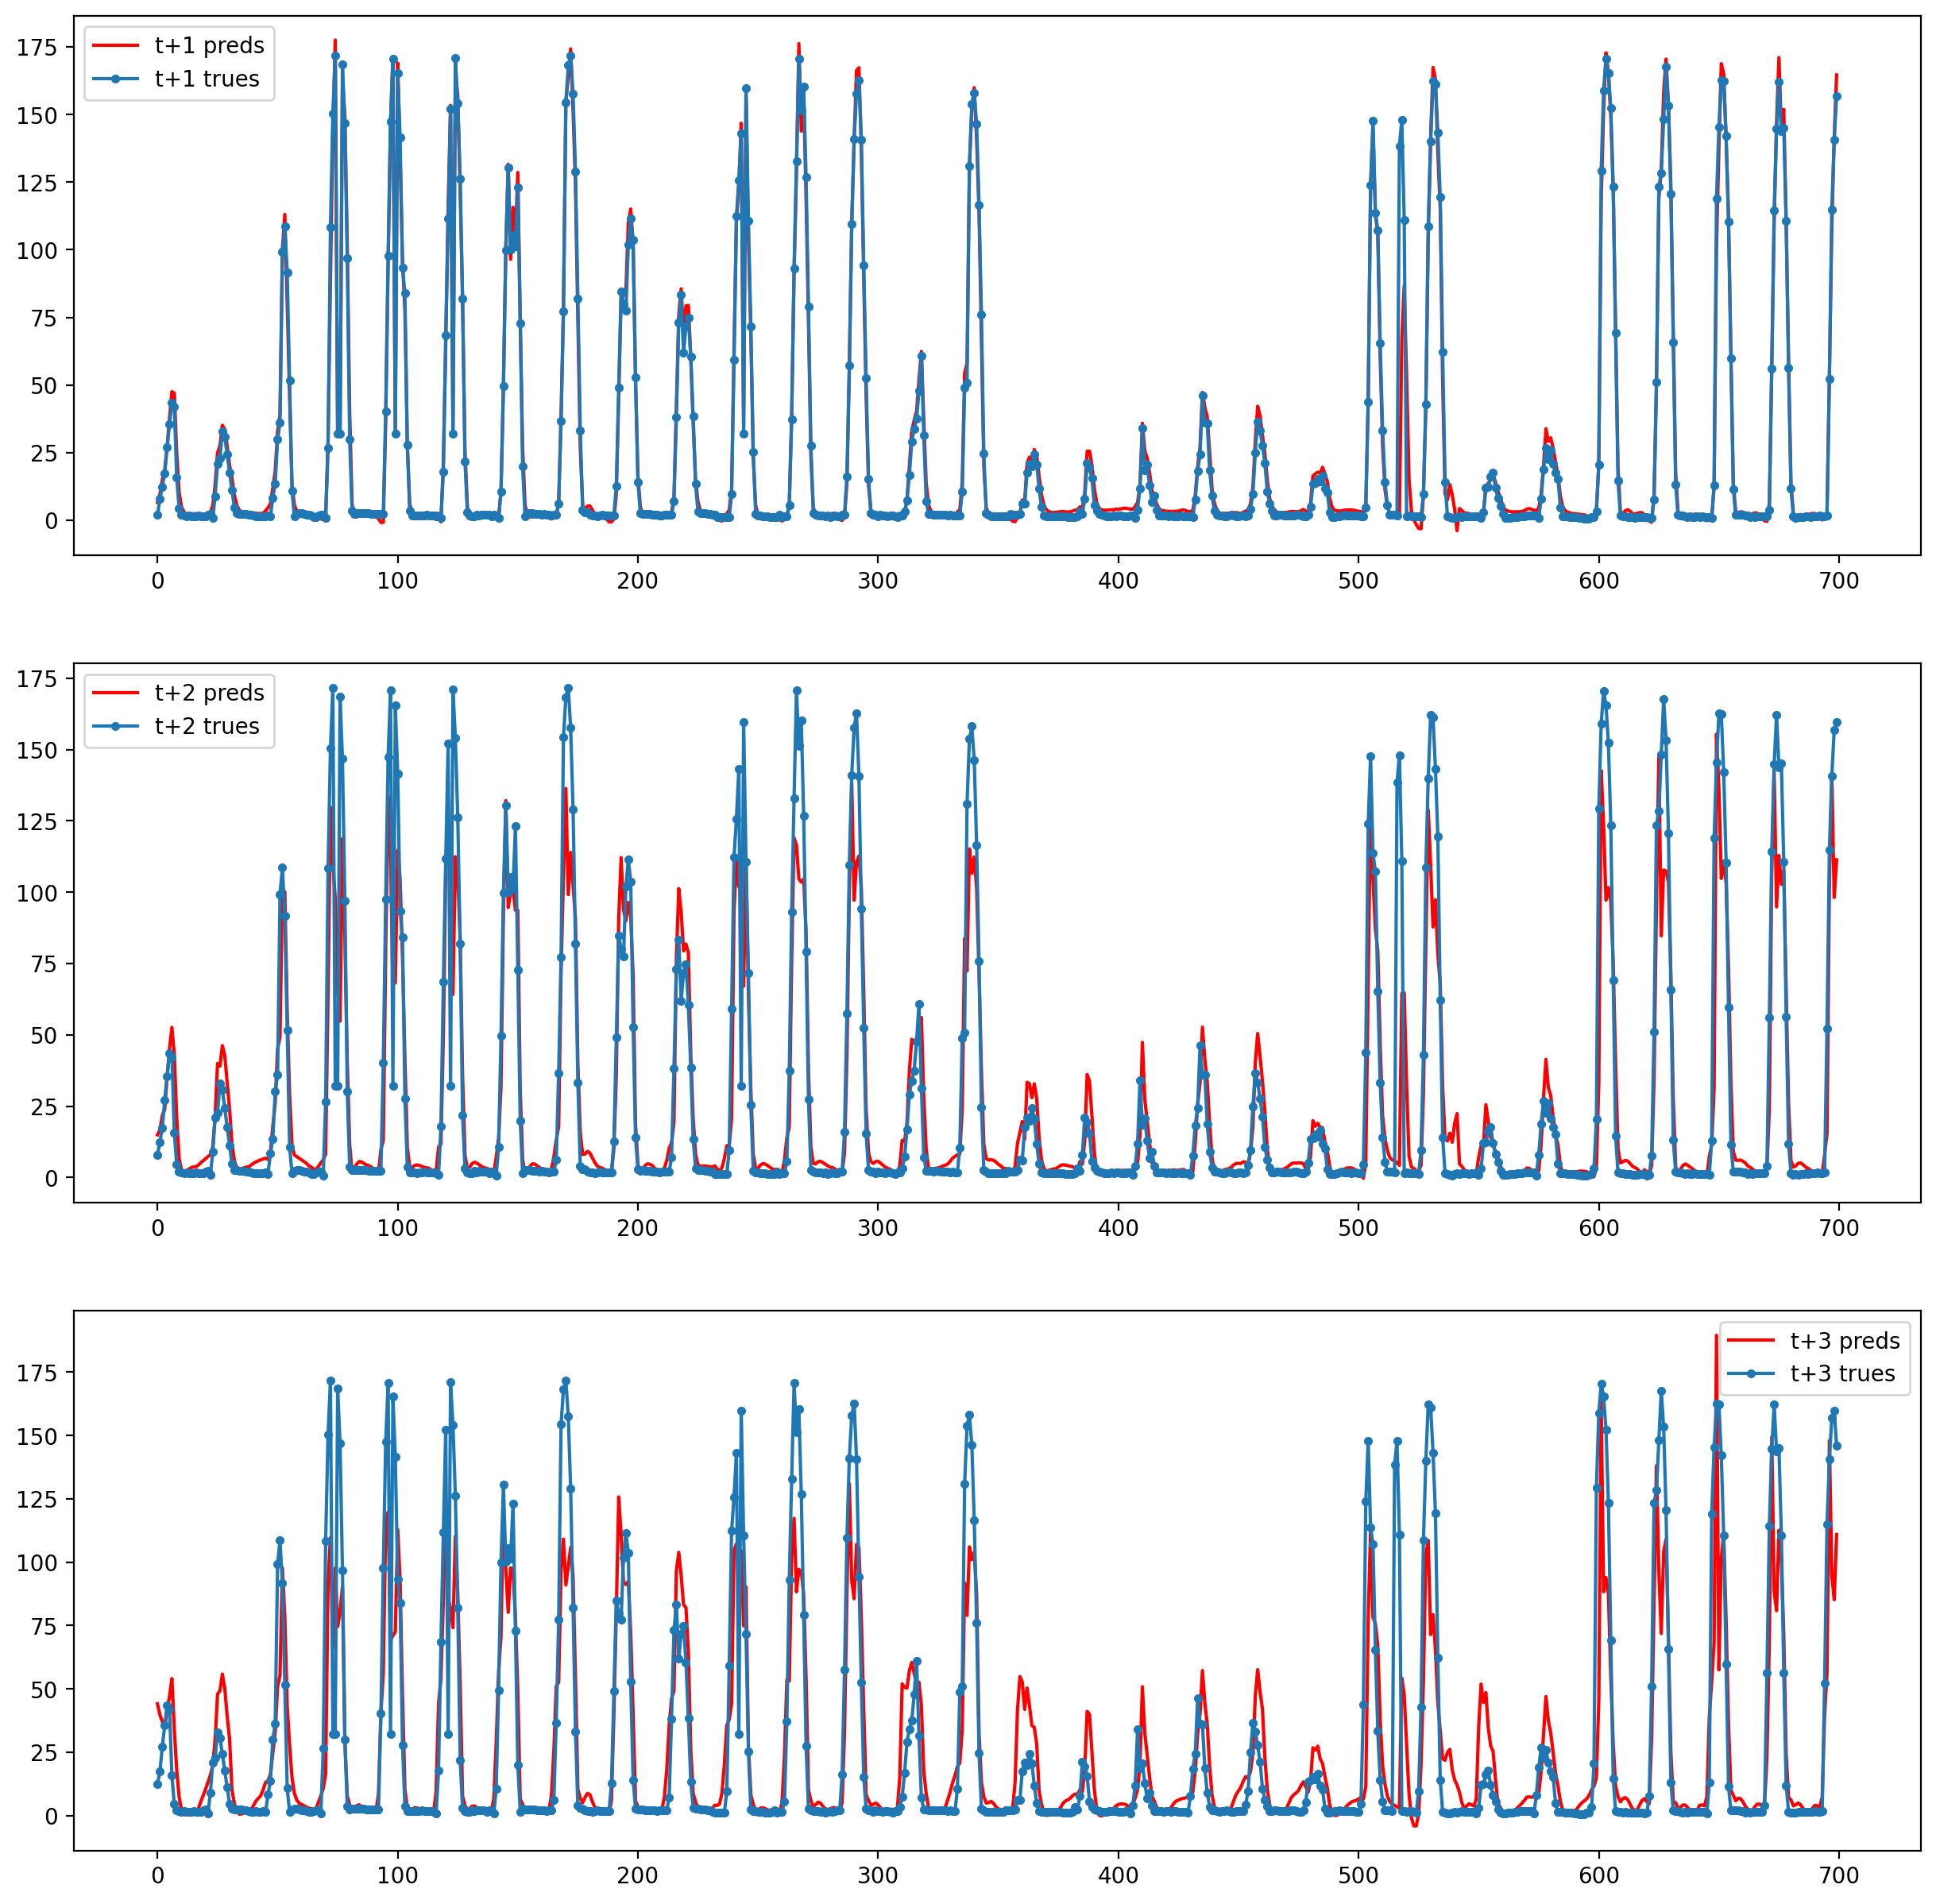

In [10]:
plot_forecasts(actuals, forecasts)

In [11]:
np.std(actuals[:, 0])

45.814670467004404

In [12]:
# create a table where we can see predictions and their difference

opt_df = pd.DataFrame(
    index=dataset.index[-len(actuals)+1:],
    data={
        'PV_Power' : actuals[:-1,0],
        'pred_1h' : forecasts[1:,0],
        'pred_2h' : forecasts[1:,1],
        'pred_3h' : forecasts[1:,2],
    }
)

opt_df['diff_from_1h_plan'] = opt_df['PV_Power'] - opt_df['pred_1h'].shift(1)

opt_df['diff_from_2h_plan'] = opt_df['PV_Power'] - opt_df['pred_2h'].shift(2)

opt_df['diff_from_3h_plan'] = opt_df['PV_Power'] - opt_df['pred_3h'].shift(3)



In [13]:
opt_df[:200]

,PV_Power,pred_1h,pred_2h,pred_3h,diff_from_1h_plan,diff_from_2h_plan,diff_from_3h_plan
Time,,,,,,,
2017-10-20 11:00:00,1.962510,9.569145,16.693907,39.733528,NaN,NaN,NaN
2017-10-20 12:00:00,7.873243,14.915577,21.700342,37.106274,-1.695902,NaN,NaN
2017-10-20 13:00:00,12.460875,18.559736,23.829325,34.357140,-2.454702,-4.233032,NaN
2017-10-20 14:00:00,17.320198,27.125837,35.064831,41.346340,-1.239538,-4.380144,-22.413330
2017-10-20 15:00:00,27.109017,37.769020,45.128151,47.119530,-0.016820,3.279692,-9.997257
...,...,...,...,...,...,...,...
2017-10-28 14:00:00,77.415490,109.902016,96.418724,92.488640,-7.546073,-16.417869,-33.602355
2017-10-28 15:00:00,101.921954,115.063675,91.433739,72.161194,-7.980061,11.956584,9.833789
2017-10-28 16:00:00,111.549963,102.449326,70.668541,40.002808,-3.513712,15.131239,20.363913
